# COVID'19 DASHBOARD

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus.

The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes, so it’s important that you also practice respiratory etiquette (for example, by coughing into a flexed elbow). Most people infected with the COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment.  Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.

The best way to prevent and slow down transmission is be well informed about the COVID-19 virus, the disease it causes and how it spreads. Protect yourself and others from infection by washing your hands or using an alcohol based rub frequently and not touching your face. 

At this time, there are no specific vaccines or treatments for COVID-19. However, there are many ongoing clinical trials evaluating potential treatments. WHO will continue to provide updated information as soon as clinical findings become available.

In [116]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from IPython.core.display import display, HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import folium
import plotly.graph_objects as go
import seaborn as sns

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import plotly.io as pio
pio.templates.default = "plotly_dark"
plt.style.use('dark_background')

In [117]:
#HTML for displaying cover picture
# display(HTML("<img src='./Images/bluered.jpg' width='1000' height='500'>"))

display(HTML('<img src="./Images/corona-virus-getty.jpg" style="width:1400px;height:500px;">'))

In [118]:
death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
country = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')

In [119]:
# death.head()
# confirmed.head()
# recovered.head()
# country.tail()

In [120]:
#renaming column names
death = death.rename(columns={"Province/State":"state","Country/Region":"country"})
confirmed = confirmed.rename(columns={"Province/State":"state","Country/Region":"country"})
recovered = recovered.rename(columns={"Province/State":"state","Country/Region":"country"})
country = country.rename(columns={"Long_":"long","Country_Region":"country","Last_Update":"date"})

#Column names to lower case
death.columns = map(str.lower,death.columns)
confirmed.columns = map(str.lower,confirmed.columns) 
recovered.columns = map(str.lower,recovered.columns)
country.columns = map(str.lower,country.columns)

In [121]:
# Total cases in each category and num of countries affected
tot_death = int(country["deaths"].sum())
tot_confirmed = int(country["confirmed"].sum())
tot_recovered = int(country["recovered"].sum())
tot_country = country["country"].count()

In [122]:
# tot_death
# tot_confirmed
# tot_recovered
# tot_country 

In [123]:
country["date"] = pd.to_datetime(country["date"]).dt.date
country["date"] = pd.to_datetime(country["date"])
# country.dtypes

In [124]:
#HTML for displaying the above counts as a tagline
display(HTML("<div style = 'background-color: #504e4e; padding: 30px '>" +
             "<span style='color: dark; font-size:20px;margin-left:25px;'> Confirmed: "  + str(tot_confirmed) +"</span>" +
             "<span style='color: green; font-size:20px; margin-left:20px;'> Recovered: " + str(tot_recovered) + "</span>"+
             "<span style='color: red; font-size:20px;margin-left:20px;'> Deaths: " + str(tot_death) + "</span>"+
             "<span style = 'color: yellow; font-size:20px; margin-left:20px;'> Countries Affected: " + str(tot_country)+ "</span>"+
             "</div>")
       )

## Highly Affected Countries
Enter the number of countries

In [125]:
sorted_country = country.sort_values("confirmed",ascending=False)
# sorted_country.iloc[:,[0,1,4,5,6,7,8,11]]

In [126]:
fig = go.FigureWidget( layout=go.Layout() )
def highlight(x):
    r = 'background-color: red'
    y = 'background-color: purple'
    g = 'background-color: grey'
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    df.iloc[:, 2] = y
    df.iloc[:, 3] = r
    df.iloc[:, 4] = g
    
    return df

def num_countries(n):
    n = int(n)
    return sorted_country.iloc[:,[0,1,4,5,6,7,8,11]].head(n).style.apply(highlight, axis=None)
interact(num_countries,n='10')

ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none' # uncomment this, run cell again - then the graph/figure disappears
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(Text(value='10', description='n'), Output()), _dom_classes=('widget-interact',))

    'data': [], 'layout': {'template': '...'}
}),), layout=Layout(border='solid …

In [127]:
def bubble_chart(n):
    fig = px.scatter(sorted_country.head(n), x="country", y="confirmed", size="confirmed", color="country",
               hover_name="country", size_max = 80)
    fig.update_layout(
    title=str(n) +" Worst hit countries",
    xaxis_title="Countries",
    yaxis_title="Confirmed Cases",
    width = 700
    )
    fig.show();
interact(bubble_chart, n=10)
ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none' # uncomment this, run cell again - then the graph/figure disappears
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(IntSlider(value=10, description='n', max=30, min=-10), Output()), _dom_classes=('widget-…

    'data': [], 'layout': {'template': '...'}
}),), layout=Layout(border='solid …

## Countrywise Confirmed-Death Graph

In [128]:
def plot_cases_of_a_country(country):
    labels = ['confirmed', 'deaths']
    colors = ['blue', 'red']
    mode_size = [6, 8]
    line_size = [2, 2]
    
    df_list = [confirmed, death]
    
    fig = go.Figure();
    
    for i, df in enumerate(df_list):
        x_data = np.array(list(df.iloc[:, 4:].columns))
        y_data = np.sum(np.asarray(df[df['country'] == country].iloc[:,4:]),axis = 0)
            
        fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
        text = "Total " + str(labels[i]) +": "+ str(y_data[-1])
        ));
    
    fig.update_layout(
        title="COVID'19 Confirmed Vs Deaths: " + country,
        xaxis_title='Date',
        yaxis_title='Confirmed Cases',
        margin=dict(l=20, r=20, t=40, b=20),
        paper_bgcolor="black",
        width = 800,
        
    );
    
    fig.update_yaxes(type="linear")
    fig.show();
    
interact(plot_cases_of_a_country, country=country["country"])

ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none' # uncomment this, run cell again - then the graph/figure disappears
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

    'data': [], 'layout': {'template': '...'}
}),), layout=Layout(border='solid …

## Cases in 10 most affected countries

### Confirmed Cases

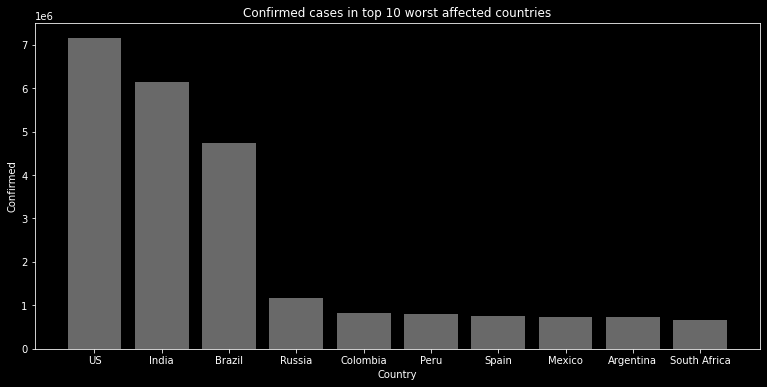

In [129]:
#Bar chart for confirmed cases in worst affected countries
# px.bar(
#     sorted_country.head(10)[::-1],
#     y = "country",
#     x = "confirmed",
#     title= "Top 10 worst affected countries", # the axis names
#     color_discrete_sequence=["darkslategrey"],
#     orientation = "h",
#     height=500,
#     width=800
# )
fig2 = plt.figure(figsize = (13, 6)) 
plt.bar(sorted_country.head(10)["country"], sorted_country.head(10)["confirmed"], color ='dimgray',  
        width = 0.8) 
  
plt.xlabel("Country") 
plt.ylabel("Confirmed") 
plt.title("Confirmed cases in top 10 worst affected countries") 
plt.show() 

### Recovered Cases

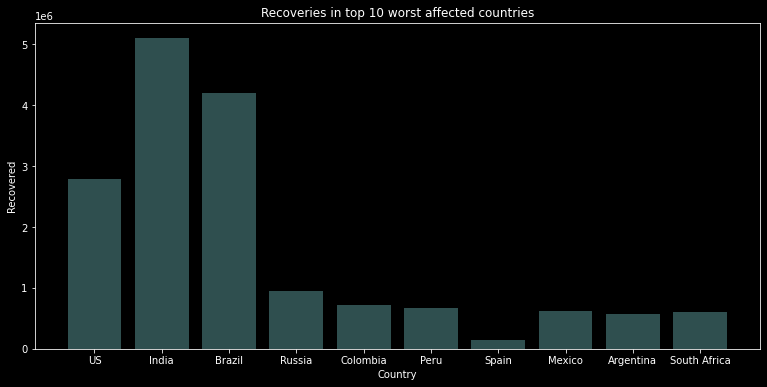

In [130]:
#Bar chart for recovered cases in worst affected countries
fig2 = plt.figure(figsize = (13, 6)) 
plt.bar(sorted_country.head(10)["country"], sorted_country.head(10)["recovered"], color ='darkslategrey',  
        width = 0.8) 
  
plt.xlabel("Country") 
plt.ylabel("Recovered") 
plt.title("Recoveries in top 10 worst affected countries") 
plt.show() 

### Deaths

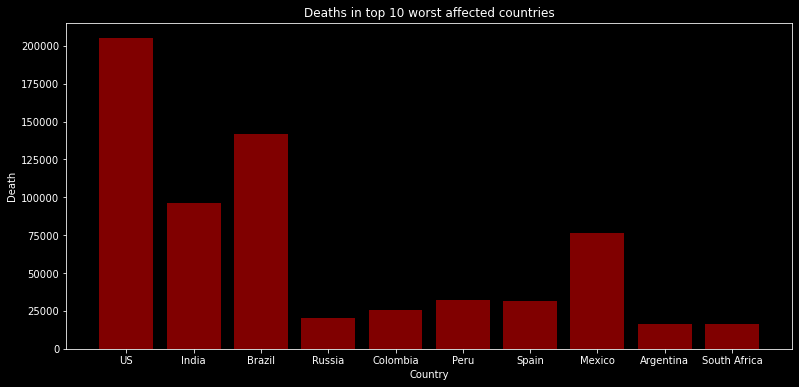

In [131]:
#Bar chart for deaths cases in worst affected countries
fig2 = plt.figure(figsize = (13, 6)) 
plt.bar(sorted_country.head(10)["country"], sorted_country.head(10)["deaths"], color ='maroon',  
        width = 0.8) 
  
plt.xlabel("Country") 
plt.ylabel("Death") 
plt.title("Deaths in top 10 worst affected countries") 
plt.show() 

In [132]:
world_map = folium.Map(location=[11,0], tiles="CartoDB dark_matter", zoom_start=2, max_zoom = 6, min_zoom = 2)


for i in range(len(confirmed)):
    folium.Circle(
        location=[confirmed.iloc[i]['lat'], confirmed.iloc[i]['long']],
        fill=True,
        radius=(int((np.log(confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='red',
        fill_color='indigo',
        tooltip = "<div style='margin: 0; background-color: black; color: white;'>"+
                    "<h4 style='text-align:center;font-weight: bold'>"+confirmed.iloc[i]['country'] + "</h4>"
                    "<hr style='margin:10px;color: white;'>"+
                    "<ul style='color: white;;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
                        "<li>Confirmed: "+str(confirmed.iloc[i,-1])+"</li>"+
                        "<li>Deaths:   "+str(death.iloc[i,-1])+"</li>"+
                        "<li>Death Rate: "+ str(np.round(death.iloc[i,-1]/(confirmed.iloc[i,-1]+1.00001)*100,2))+ "</li>"+
                    "</ul></div>",
        ).add_to(world_map)

world_map

## More Info

https://www.who.int/health-topics/coronavirus

https://www.who.int/emergencies/diseases/novel-coronavirus-2019

https://www.nature.com/articles/s41597-020-0448-0

## Link To Resources

In [ ]:
display(HTML('<a href="https://github.com/Aparna-U-Nair/COVID-19-Dashboard">Github Repo</a>'))